<a href="https://colab.research.google.com/github/AndreaMorbello/Progetto-IA2/blob/main/Notebooks/Notebook-IA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import pandas.api.types as pdt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [ ]:
# Impostazioni grafiche
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")


# Notebook Progetto Baseline

## 1. Introduzione al Progetto

### 1.1. Obiettivo del Modello

L'obiettivo di questo progetto è sviluppare un modello di regressione in grado di stimare il punteggio ELO del giocatore con i pezzi bianchi a partire da feature estratte da una singola partita.
Questo modello, denominato modello baseline, sarà successivamente confrontato con un secondo modello ... [DA COMPLETARE]

### 1.2. Limiti del Modello e ipotesi

**A. Rumore nei dati**

Questo modello stima il punteggio ELO di un giocatore utilizzando esclusivamente dati provenienti da una singola partita. Poiché la performance in una singola partita può variare significativamente rispetto al livello medio del giocatore (a causa di fattori quali concentrazione, forma del giorno, errori occasionali, o scelte strategiche particolari), stiamo di fatto lavorando con un campione altamente rumoroso dell'abilità reale del giocatore. Inoltre, il modello baseline utilizza feature non direttamente indicative della qualità del gioco (come vedremo nella sezione delle feature).

Per questi motivi, non ci aspettiamo un modello estremamente preciso e valuteremo criticamente eventuali metriche di accuratezza eccessivamente elevate, che potrebbero indicare overfitting o altre problematiche.

**B. Importanza delle feature e information leakage**

Tra le feature utilizzate (presentate nel punto 1.4 e successivamente selezionate nella sezione 3.1/b), ce n'è una chiaramente più informativa delle altre (almeno nella nostra ipotesi): `black_rating`. Questo deriva dal meccanismo di matchmaking utilizzato dai siti di scacchi online, che tendono ad accoppiare giocatori con punteggi ELO simili per garantire partite equilibrate.
(Questo non è vero universalmente, all'interno di tornei o partite amichevoli questa regola può non valere).

Di conseguenza, il modello avrà inevitabilmente una struttura approssimabile a:

**white_rating ≈ black_rating ± f(altre feature)**

dove f rappresenta una funzione correttiva basata sulle altre feature disponibili. Questa situazione rappresenta un caso di information leakage parzialmente controllato: `black_rating` contiene informazioni altamente correlate con il target, ma non lo determina completamente, lasciando spazio alle altre feature per catturare le differenze individuali e contestuali.

Analizzeremo più nel dettaglio tale correlazione nella sezione 4.1.

**C. Partite classificate vs non classificate**

È ragionevole ipotizzare che la performance del modello possa essere inferiore per le partite non classificate (rated=False), ovvero quelle che non influenzano il punteggio ELO dei giocatori. Il motivo è che molti giocatori potrebbero affrontare queste partite con minore serietà o utilizzarle per sperimentare strategie non convenzionali, dato che un'eventuale sconfitta non avrebbe conseguenze sul loro rating ufficiale.

Questa ipotesi potrà essere verificata attraverso un'analisi comparativa delle performance del modello sui due sottoinsiemi di dati.

Tali differenze saranno esplorate più nel dettaglio nella sezione 4.2.

### 1.3. Note sul Target

Il target del modello, `white_rating`, rappresenta il punteggio ELO del giocatore che conduce i pezzi bianchi. Il sistema ELO (https://it.wikipedia.org/wiki/Elo_(scacchi)) è un metodo per calcolare il livello relativo di abilità dei giocatori in giochi a due giocatori a somma zero, come gli scacchi.

**Aspetto temporale cruciale**: È fondamentale specificare che `white_rating` si riferisce al punteggio che il giocatore possedeva immediatamente prima dell'inizio della partita, non dopo la sua conclusione. Nelle partite classificate (rated=True), il punteggio ELO viene aggiornato al termine della partita in base a:
- Il rating pre-partita di entrambi i giocatori
- Il risultato effettivo della partita
- Il risultato atteso (calcolato dalla differenza di rating)
- Altri parametri come il fattore K (che dipende dal numero di partite giocate)

Il nostro obiettivo non è invertire l'algoritmo di calcolo del punteggio ELO, bensì utilizzare tale punteggio come proxy (approssimatore imperfetto ma ragionevole) del livello di abilità scacchistica del giocatore in quel momento specifico.

### 1.4. Presentazione del Dataset

Il dataset utilizzato proviene da Kaggle ed è disponibile al seguente indirizzo:
https://www.kaggle.com/datasets/datasnaek/chess

Il dataset originale contiene 20.058 partite di scacchi disputate sulla piattaforma Lichess. Ogni partita è descritta dalle seguenti variabili:

- **id**: Stringa alfanumerica identificativa univoca della partita
- **rated**: Variabile booleana che indica se la partita è classificata (True) e quindi influenza il rating ELO dei giocatori, oppure non classificata (False)
- **created_at**: Timestamp di inizio della partita in formato Unix time
- **last_move_at**: Timestamp di conclusione della partita in formato Unix time
- **turns**: Numero di turni completi, dove ogni turno è definito come una coppia di mosse (bianco-nero)
- **victory_status**: Modalità di conclusione della partita (scacco matto, abbandono, tempo esaurito, stallo, ecc.)
- **winner**: Colore del giocatore vincente (white, black) o draw in caso di patta
- **increment_code**: Formato temporale della partita espresso come "minuti iniziali+secondi di incremento per mossa" (es. "10+0" indica 10 minuti per giocatore senza incremento)
- **white_id**: Nome utente del giocatore con i pezzi bianchi
- **white_rating**: Punteggio ELO del giocatore bianco (pre-partita)
- **black_id**: Nome utente del giocatore con i pezzi neri
- **black_rating**: Punteggio ELO del giocatore nero (pre-partita)
- **moves**: Sequenza completa delle mosse della partita in notazione algebrica standard (SAN - Standard Algebraic Notation)
- **opening_eco**: Codice di classificazione dell'apertura secondo l'Encyclopaedia of Chess Openings (ECO)
- **opening_name**: Nome descrittivo dell'apertura utilizzata
- **opening_ply**: Numero di ply (mezze-mosse) che costituiscono la fase di apertura classificata della partita

### 1.5. La feature `Moves`
Essendo difficilmente gestibile, ma contenendo informazioni che ci aspettiamo essere importanti per la valutazione dell'ELO del giocatore, nel punto 2 ci occupiamo di estrarre ulteriori features da questa, che verrà esclusa dalla lista finale delle features

### 1.6. Importazione del Dataset

In [ ]:
###INSERIRE CODICE PER IMPORTAZIONE

In [ ]:
## Quando ultimeremo il codice sarebbe meglio non fare montare il drive.
from google.colab import drive
drive.mount('/content/drive')

df=pd.read_csv("/content/drive/MyDrive/games.csv")
df_originale = df.copy() # Salviamo una copia del DataFrame originale

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Estrazione feature da `moves`
Per valutare la capacità di un giocatore un essere umano dovrebbe guardare le mosse fatte nella partita, ragionando sulla loro correttezza, il tipo di piano formulato, eventuali blunder e altri indicatori. Nel nostro modello però, un'analisi accurata delle singole mosse e la valutazione di ciascuna posizione saliente non è possibile senza complicare esponenzialmente la questione. Per questo proveremo ad estrarre almeno qualche informazione dalle mosse, prima di rimuoverle dal dataframe. Valuteremo successivamente la rilevanza di queste nuove feature, decidendo se conservarle o scartarle.

In [ ]:
moves = df_originale['moves']
all_moves_split = moves.str.split()
white_moves = all_moves_split.apply(lambda x: x[0::2])
black_moves = all_moves_split.apply(lambda x: x[1::2])

def calc_rate(moves_series, char):
    """Calcola la frequenza di un carattere per mossa."""
    counts = moves_series.apply(lambda x: sum(char in m for m in x))
    return counts / moves_series.str.len()

df['white_captures_rate'] = calc_rate(white_moves, 'x')
df['black_captures_rate'] = calc_rate(black_moves, 'x')
df['white_checks_rate'] = calc_rate(white_moves, '+')
df['black_checks_rate'] = calc_rate(black_moves, '+')
df['white_promotions_rate'] = calc_rate(white_moves, '=')
df['black_promotions_rate'] = calc_rate(black_moves, '=')

# Arrocco (ci basta controllare la presenza di O-O, arrocco corto, perché
# O-O-O, arrocco lungo, ha O-O come sottostringa)
df['white_castled'] = white_moves.apply(lambda x: int(any('O-O' in m for m in x)))
df['black_castled'] = black_moves.apply(lambda x: int(any('O-O' in m for m in x)))

df.head(5)

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,...,opening_name,opening_ply,white_captures_rate,black_captures_rate,white_checks_rate,black_checks_rate,white_promotions_rate,black_promotions_rate,white_castled,black_castled
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,...,Slav Defense: Exchange Variation,5,0.285714,0.166667,0.000000,0.166667,0.000000,0.0,0,0
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,...,Nimzowitsch Defense: Kennedy Variation,4,0.250000,0.375000,0.125000,0.125000,0.000000,0.0,0,0
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,...,King's Pawn Game: Leonardis Variation,3,0.451613,0.100000,0.258065,0.000000,0.000000,0.0,0,0
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,...,Queen's Pawn Game: Zukertort Variation,3,0.322581,0.133333,0.387097,0.000000,0.000000,0.0,1,1
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,...,Philidor Defense,5,0.291667,0.212766,0.083333,0.085106,0.020833,0.0,1,1


Abbiamo dunque aggiunto:

Features Numeriche:
*   **white_captures_rate**: Numero di catture eseguite dal bianco / numero di mosse eseguite dal bianco
*   **black_captures_rate**: Numero di catture eseguie dal nero / numero di mosse eseguite dal nero
*   **white_checks_rate**: Numero di scacchi dati dal bianco / numero di mosse eseguite dal bianco
*   **black_checks_rate**: Numero di scacchi dati dal nero / numero di mosse eseguite dal nero
*   **white_promotion_rate**: Numero di promozioni eseguite dal bianco / numero di mosse eseguite dal bianco
*   **black_checks_rate**: Numero di promozioni eseguite dal nero / numero di mosse eseguite dal nero

Features Categoriali:
*   **white_casteled**: Il bianco ha arroccato
*   **black_casteled**: Il nero ha arroccato


## 3. Pulizia e preprocessing
### 3.1. Pulizia

#### a) Rimozione dei duplicati

Durante l'ispezione iniziale del dataset è stata rilevata la presenza di 945 record con identificativo (`id`) duplicato. Dopo aver verificato che si trattasse effettivamente di righe identiche in tutte le colonne, e non di partite diverse erroneamente associate allo stesso ID, abbiamo proceduto alla rimozione delle righe ridondanti, mantenendo una sola istanza per ciascun ID univoco.

In [ ]:
# Individuiamo gli ID che compaiono più di una volta
dup_ids = df['id'].value_counts()
dup_ids = dup_ids[dup_ids > 1]

print(f"Numero di ID duplicati: {len(dup_ids)}")

colonne_da_controllare = [c for c in df.columns if c != 'id']

identical_check = (
    df[df['id'].isin(dup_ids.index)]
    .groupby('id')[colonne_da_controllare]
    .nunique()
    .max(axis=1)
)

identical_check.value_counts()

Numero di ID duplicati: 813


,count
2,516
1,297


In [ ]:
# Notiamo che alcune righe (516) non condividono valori identici per tutte le colonne, verifichiamo perché:
id_problematici = identical_check[identical_check > 1].index

df[df['id'].isin(id_problematici)] \
  .groupby('id')[colonne_da_controllare] \
  .nunique() \
  .head()

# Le colonne non identiche sono quelle di inizio e fine partita, dunque il problema
# è probabilmente dovuto a un problema di datatype o di misurazione nel dataset.
# Le partite sono semanticamente identiche.
# Possiamo quindi procedere con la rimozione dei duplicati.

df = df.drop_duplicates(subset='id').reset_index(drop=True)

b) *Eliminazione delle colonne del dataframe non necessarie*:
Saranno certamente ininfluenti gli ID dei giocatori, ID della partita e il nome dell'apertura (prediligeremo usare il più rigoroso opening ECO).
Il discorso è più complicato per quanto riguarda le mosse. Intuitivamente per valutare il livello di un giocatore queste sarebbero fondamentali, tuttavia, almeno per il modello baseline, proveremo a fare le nostre valutazioni senza prenderle in considerazione.

In [ ]:
df = df.drop(columns=['white_id','black_id','id','opening_name','moves'])

c) *Trasformazione delle colonne di inizio e fine partita in una colonna di durata*

In [ ]:
#Ora convertiamo le colonne di inizio e fine partita, che sono in formato Unix time, in formato datetime
#Dopodichè inseriremo una più semplice colonna di durata partita al posto delle due colonne iniziali

df_times = df[['created_at','last_move_at']].copy()

df_times['created_at_dt'] = pd.to_datetime(df_times['created_at']/1000, unit='s', origin='unix')

df_times['last_move_at_dt'] = pd.to_datetime(df_times['last_move_at']/1000, unit='s', origin='unix')

df_times['created_time'] = df_times['created_at_dt'].dt.time
df_times['last_move_time'] = df_times['last_move_at_dt'].dt.time
df_times['duration_seconds'] = (df_times['last_move_at_dt'] - df_times['created_at_dt']).dt.total_seconds()

#Adesso che abbiamo la durata della partita in secondi, inseriamo la colonna nel dataframe e rimuoviamo quelle iniziali

df=df.drop(columns=['created_at','last_move_at'])
df=df.join(df_times['duration_seconds'])

#Ora invece ci occupiamo della colonna 'increment_code', che è della forma "X+Y"
#dove X sono i minuti concessi a ciascun giocatore per giocare le proprie mosse e Y
#è il tempo che gli viene riaggiunto una volta giocata la mossa.
#Vogliamo separare questi due valori e tenerli in colonne separate

#Split di increment_code in due colonne
df[['base_time', 'increment_time']] = (
    df['increment_code'].str.split('+', expand=True).astype(int))

#Rimuoviamo la colonna originale
df = df.drop(columns=['increment_code'])

df.tail(5)

,rated,turns,victory_status,winner,white_rating,black_rating,opening_eco,opening_ply,white_captures_rate,black_captures_rate,white_checks_rate,black_checks_rate,white_promotions_rate,black_promotions_rate,white_castled,black_castled,duration_seconds,base_time,increment_time
19108,True,24,resign,white,1691,1220,A80,2,0.166667,0.166667,0.166667,0.000000,0.000000,0.0,1,0,321.734,10,10
19109,True,82,mate,black,1233,1196,A41,2,0.219512,0.292683,0.097561,0.219512,0.000000,0.0,0,1,744.219,10,0
19110,True,35,mate,white,1219,1286,D00,3,0.111111,0.117647,0.222222,0.000000,0.000000,0.0,0,1,172.834,10,0
19111,True,109,resign,white,1360,1227,B07,4,0.254545,0.203704,0.018182,0.111111,0.018182,0.0,0,1,946.699,10,0
19112,True,78,mate,black,1235,1339,D00,3,0.256410,0.256410,0.025641,0.230769,0.000000,0.0,0,1,736.699,10,0


d) Gestione delle variabili categoriche:

- Opening ECO. Questo è un sistema complesso. Per i nostri scopi sarà sufficiente sapere che classifica le aperture in cinque grandi famiglie:
A -> Aperture atipiche; B -> Sistemi semiaperti; C -> Partite di Re aperte e Francesi;  D -> Partite di Donna;                             E -> Difese Indiane.    
Questa è un'approsimazione ma ci consente di creare comunque dei dummy ristretti ma informativi riguardo al tipo di apertura giocata.


In [ ]:
# Opening ECO semplificato

df['opening_category'] = df['opening_eco'].str[0]
df = df.drop(columns=['opening_eco'])

e) Possiamo ora procedere alla dummyficazione di tutte le colonne categoriali rimanenti.

In [ ]:
colonne_dummy = ['rated', 'victory_status', 'winner', 'opening_category']

df = pd.get_dummies(df, columns=colonne_dummy, dtype=int, drop_first=False)

df.head()

,turns,white_rating,black_rating,opening_ply,white_captures_rate,black_captures_rate,white_checks_rate,black_checks_rate,white_promotions_rate,black_promotions_rate,...,victory_status_outoftime,victory_status_resign,winner_black,winner_draw,winner_white,opening_category_A,opening_category_B,opening_category_C,opening_category_D,opening_category_E
0,13,1500,1191,5,0.285714,0.166667,0.000000,0.166667,0.000000,0.0,...,1,0,0,0,1,0,0,0,1,0
1,16,1322,1261,4,0.250000,0.375000,0.125000,0.125000,0.000000,0.0,...,0,1,1,0,0,0,1,0,0,0
2,61,1496,1500,3,0.451613,0.100000,0.258065,0.000000,0.000000,0.0,...,0,0,0,0,1,0,0,1,0,0
3,61,1439,1454,3,0.322581,0.133333,0.387097,0.000000,0.000000,0.0,...,0,0,0,0,1,0,0,0,1,0
4,95,1523,1469,5,0.291667,0.212766,0.083333,0.085106,0.020833,0.0,...,0,0,0,0,1,0,0,1,0,0


## 4. Analisi dei dati

Nota: L'analisi Esplorativa è stata condotta sull'intero dataset. Data la stabilità delle correlazioni su campioni di queste dimensioni e la natura non-iterativa della scelta delle features, abbiamo ritenuto il rischio di data leakage trascurabile.

In [ ]:
# Dividiamo colonne categoriche e numeriche

numeric_columns = []
categorical_columns = []

for col in df.columns:
    if pdt.is_numeric_dtype(df[col]):
        if pdt.is_integer_dtype(df[col]) and df[col].isin([0, 1]).all():
            categorical_columns.append(col)
        else:
            numeric_columns.append(col)

print("Colonne Numeriche:", numeric_columns)
print("\nColonne Categoriche:", categorical_columns)


# Creiamo una copia del dataset in questo stato

df_temp = df.copy()
df_temp.head(5)

Colonne Numeriche: ['turns', 'white_rating', 'black_rating', 'opening_ply', 'white_captures_rate', 'black_captures_rate', 'white_checks_rate', 'black_checks_rate', 'white_promotions_rate', 'black_promotions_rate', 'duration_seconds', 'base_time', 'increment_time']

Colonne Categoriche: ['white_castled', 'black_castled', 'rated_False', 'rated_True', 'victory_status_draw', 'victory_status_mate', 'victory_status_outoftime', 'victory_status_resign', 'winner_black', 'winner_draw', 'winner_white', 'opening_category_A', 'opening_category_B', 'opening_category_C', 'opening_category_D', 'opening_category_E']


,turns,white_rating,black_rating,opening_ply,white_captures_rate,black_captures_rate,white_checks_rate,black_checks_rate,white_promotions_rate,black_promotions_rate,...,victory_status_outoftime,victory_status_resign,winner_black,winner_draw,winner_white,opening_category_A,opening_category_B,opening_category_C,opening_category_D,opening_category_E
0,13,1500,1191,5,0.285714,0.166667,0.000000,0.166667,0.000000,0.0,...,1,0,0,0,1,0,0,0,1,0
1,16,1322,1261,4,0.250000,0.375000,0.125000,0.125000,0.000000,0.0,...,0,1,1,0,0,0,1,0,0,0
2,61,1496,1500,3,0.451613,0.100000,0.258065,0.000000,0.000000,0.0,...,0,0,0,0,1,0,0,1,0,0
3,61,1439,1454,3,0.322581,0.133333,0.387097,0.000000,0.000000,0.0,...,0,0,0,0,1,0,0,0,1,0
4,95,1523,1469,5,0.291667,0.212766,0.083333,0.085106,0.020833,0.0,...,0,0,0,0,1,0,0,1,0,0


### 4.1. Correlazione fra `white_rating` e `black_rating`

Come menzionato nell'introduzione, ci aspettiamo una forte correlazione tra i rating dei due giocatori, data la natura del matchmaking. Calcoliamo il coefficiente di correlazione di Pearson e visualizziamo la relazione.

Correlazione tra white_rating e black_rating: 0.6366


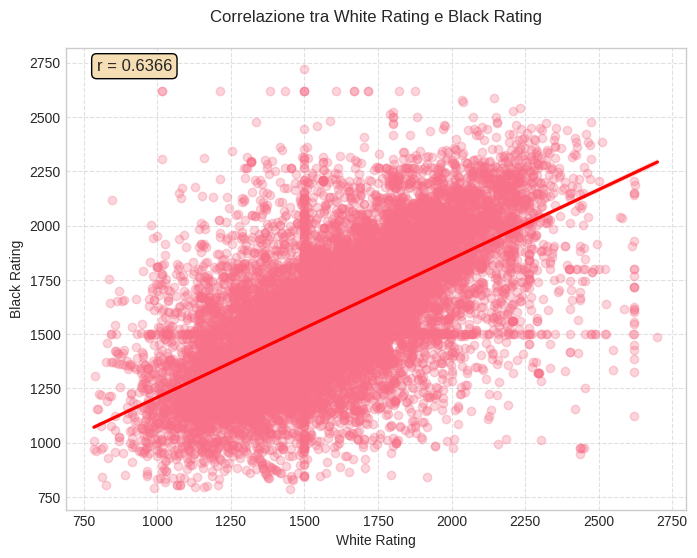

In [ ]:
correlation = df['white_rating'].corr(df['black_rating'])
print(f"Correlazione tra white_rating e black_rating: {correlation:.4f}")

plt.figure(figsize=(8, 6))
sns.regplot(x='white_rating', y='black_rating', data=df,
            scatter_kws={'alpha': 0.3}, line_kws={'color': 'red'})
plt.title('Correlazione tra White Rating e Black Rating' + '\n')
plt.xlabel('White Rating')
plt.ylabel('Black Rating')

plt.annotate(f'r = {correlation:.4f}', xy=(0.05, 0.95), xycoords='axes fraction',
             fontsize=12, bbox=dict(boxstyle='round', facecolor='wheat'))

plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Per quanto una correlazione ci sia, come ipotizzato, non sembra essere tale da rendere il problema banale. Rimane la feature più informativa, ma non l'unica feature influente.

### 4.2. Differenza Rated vs Not-Rated.
Nell'introduzione abbiamo ipotizzato ci fosse una differenza sostanziale fra le partite rated (cioè che valgono per la variazione ELO del giocatore) e quelle not-rated (cioè che viceversa non valgono per il calcolo di tale variazione).
Proviamo ad analizzare la variazione delle features e del target in questi due sottoinsiemi del dataset:

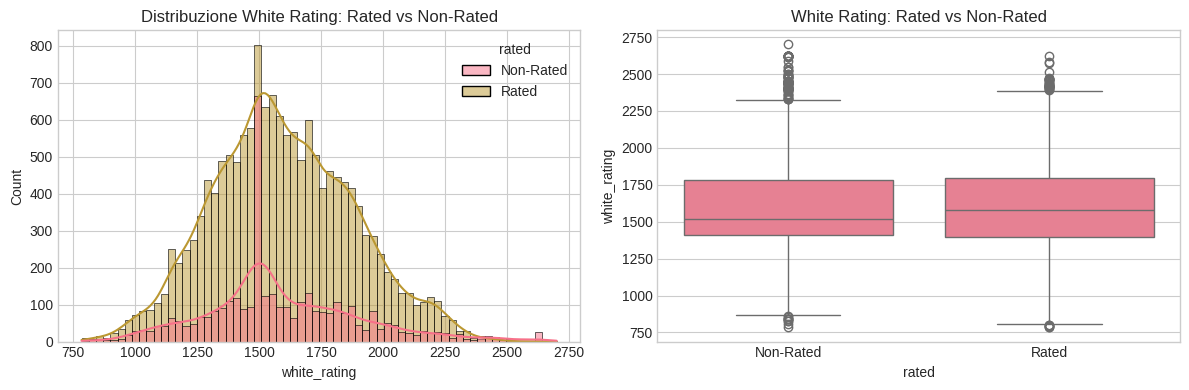


Statistiche Rated vs Non-Rated:
             count    mean    std    min     25%     50%     75%     max
rated                                                                   
Non-Rated   3646.0  1595.9  315.9  788.0  1412.0  1515.0  1779.8  2700.0
Rated      15467.0  1597.6  283.6  784.0  1399.0  1577.0  1794.0  2622.0


In [ ]:
df_temp['rated'] = df['rated_True'].map({1: 'Rated', 0: 'Non-Rated'})

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Distribuzione
sns.histplot(data=df_temp, x='white_rating', hue='rated', kde=True, ax=axes[0])
axes[0].set_title('Distribuzione White Rating: Rated vs Non-Rated')

    # Box plot
sns.boxplot(data=df_temp, x='rated', y='white_rating', ax=axes[1])
axes[1].set_title('White Rating: Rated vs Non-Rated')

plt.tight_layout()
plt.show()

print("\nStatistiche Rated vs Non-Rated:")
print(df_temp.groupby('rated')['white_rating'].describe().round(1))


Contrariamente a quanto ipotizzato, la differenza fra partite rated e non rated non sembra essere particolarmente significativa.

###4.3. Analisi del Target `white_rating`

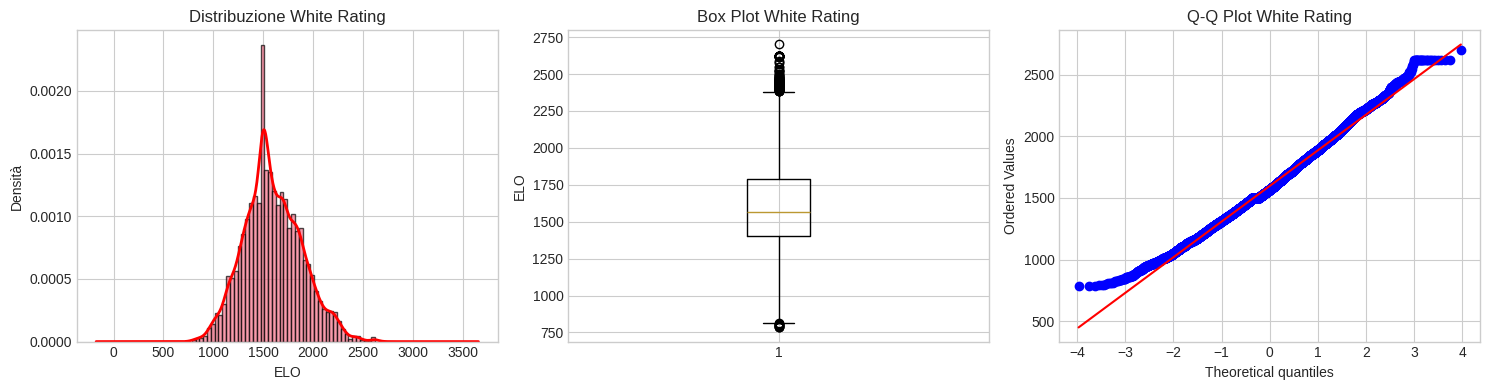

STATISTICHE TARGET (white_rating)
count    19113.000000
mean      1597.300005
std        290.022740
min        784.000000
25%       1401.000000
50%       1567.000000
75%       1792.000000
max       2700.000000
Name: white_rating, dtype: float64

Skewness: 0.2909
Kurtosis: 0.0216


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1a. Istogramma con KDE
axes[0].hist(df['white_rating'], bins=50, density=True, alpha=0.7, edgecolor='black')
df['white_rating'].plot.kde(ax=axes[0], color='red', linewidth=2)
axes[0].set_title('Distribuzione White Rating')
axes[0].set_xlabel('ELO')
axes[0].set_ylabel('Densità')

# 1b. Box plot
axes[1].boxplot(df['white_rating'], vert=True)
axes[1].set_title('Box Plot White Rating')
axes[1].set_ylabel('ELO')

# 1c. QQ plot (verifica normalità)
stats.probplot(df['white_rating'], dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot White Rating')

plt.tight_layout()
plt.show()

# Statistiche descrittive del target
print("STATISTICHE TARGET (white_rating)")
print(df['white_rating'].describe())
print(f"\nSkewness: {df['white_rating'].skew():.4f}")
print(f"Kurtosis: {df['white_rating'].kurtosis():.4f}")

La distribuzione del Target risulta molto simile ad una distribuzione normale se non per una lieve coda verso destra (giocatori con ELO alto). Non crediamo sia necessaria alcuna azione correttiva.

### 4.4. Matrice di Correlazione
Usiamo una matrice di correlazione per osservare il rapporto delle fature numeriche con il Target.

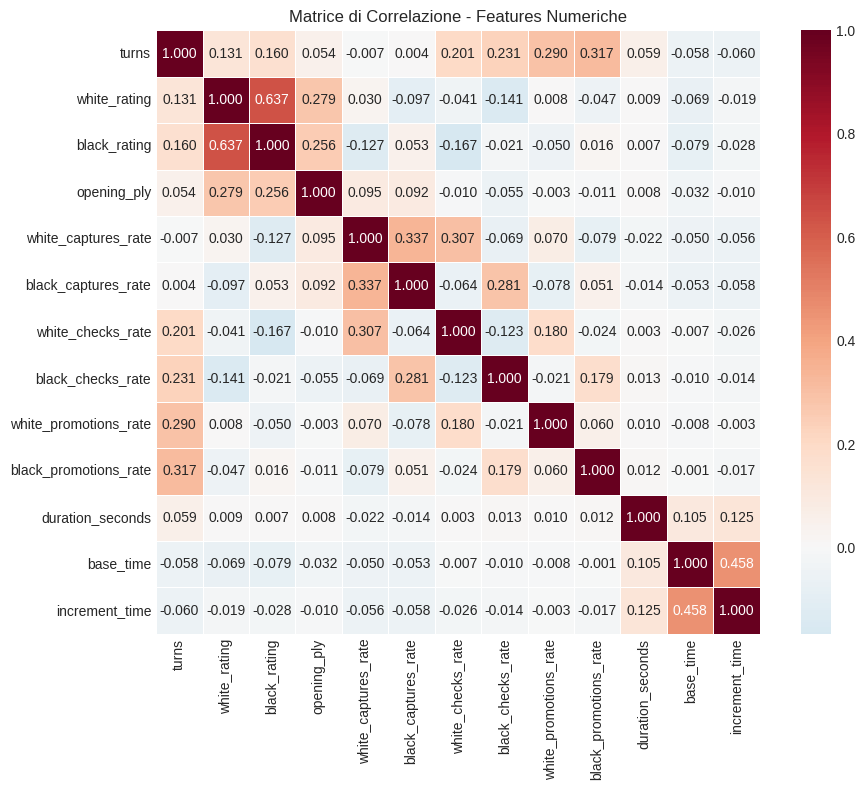

In [ ]:
correlation_matrix = df[numeric_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0,
            fmt='.3f', square=True, linewidths=0.5)
plt.title('Matrice di Correlazione - Features Numeriche')
plt.tight_layout()
plt.show()


### 4.5. Correlazioni con il Target

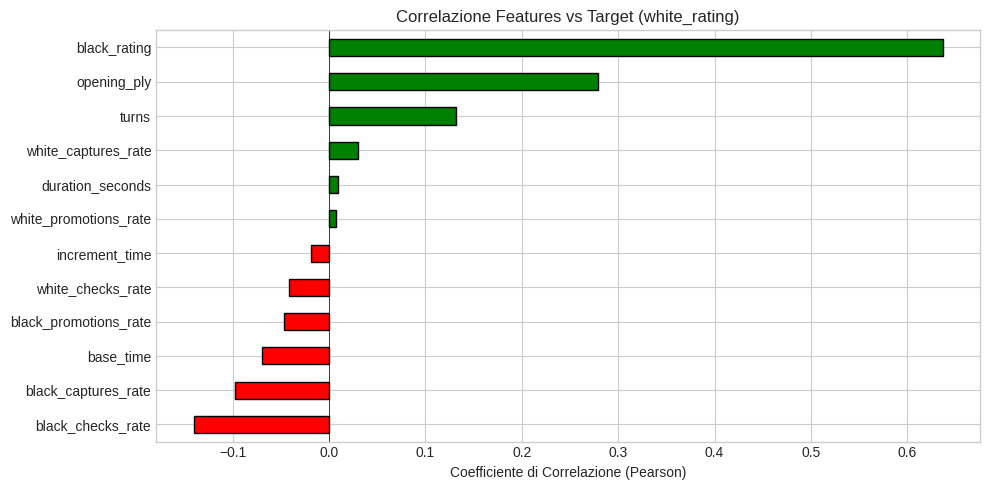


Correlazioni con white_rating:
black_rating             0.636569
opening_ply              0.278861
turns                    0.131335
white_captures_rate      0.030366
duration_seconds         0.009257
white_promotions_rate    0.007598
increment_time          -0.019090
white_checks_rate       -0.041297
black_promotions_rate   -0.047160
base_time               -0.069447
black_captures_rate     -0.097491
black_checks_rate       -0.140688
Name: white_rating, dtype: float64


In [ ]:
target_corr = correlation_matrix['white_rating'].drop('white_rating').sort_values()

plt.figure(figsize=(10, 5))
colors = ['green' if x > 0 else 'red' for x in target_corr.values]
target_corr.plot(kind='barh', color=colors, edgecolor='black')
plt.title('Correlazione Features vs Target (white_rating)')
plt.xlabel('Coefficiente di Correlazione (Pearson)')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

print("\nCorrelazioni con white_rating:")
print(target_corr.sort_values(ascending=False))


**Interpretazione delle correlazioni:**

Le feature mostrano una chiara gerarchia di potere predittivo:

**Feature informative (da mantenere):**
- `black_rating` (+0.64): Correlazione forte, come atteso dal matchmaking
- `opening_ply` (+0.28): Giocatori esperti conoscono più teoria delle aperture
- `turns` (+0.13): Partite più lunghe indicano giocatori leggermente più forti
- `black_checks_rate` (-0.14): Se il nero dà molti scacchi, il bianco è probabilmente sotto attacco (più debole)
- `black_captures_rate` (-0.10): Se il nero cattura molto, il bianco sta perdendo materiale

**Feature non informative (da escludere):**
- `duration_seconds` (+0.01): Correlazione nulla, inoltre 44.6% dei valori è corrotto
- `base_time`, `increment_time` (~0): Il formato temporale non predice l'ELO
- `white_*_rate` (~0): Le azioni del bianco non correlano col suo stesso rating (sorprendente ma coerente: conta di più come reagisce l'avversario)
- `*_promotions_rate` (~0): Troppo rare per essere informative


### 4.6. Analisi Univariata delle Features numeriche

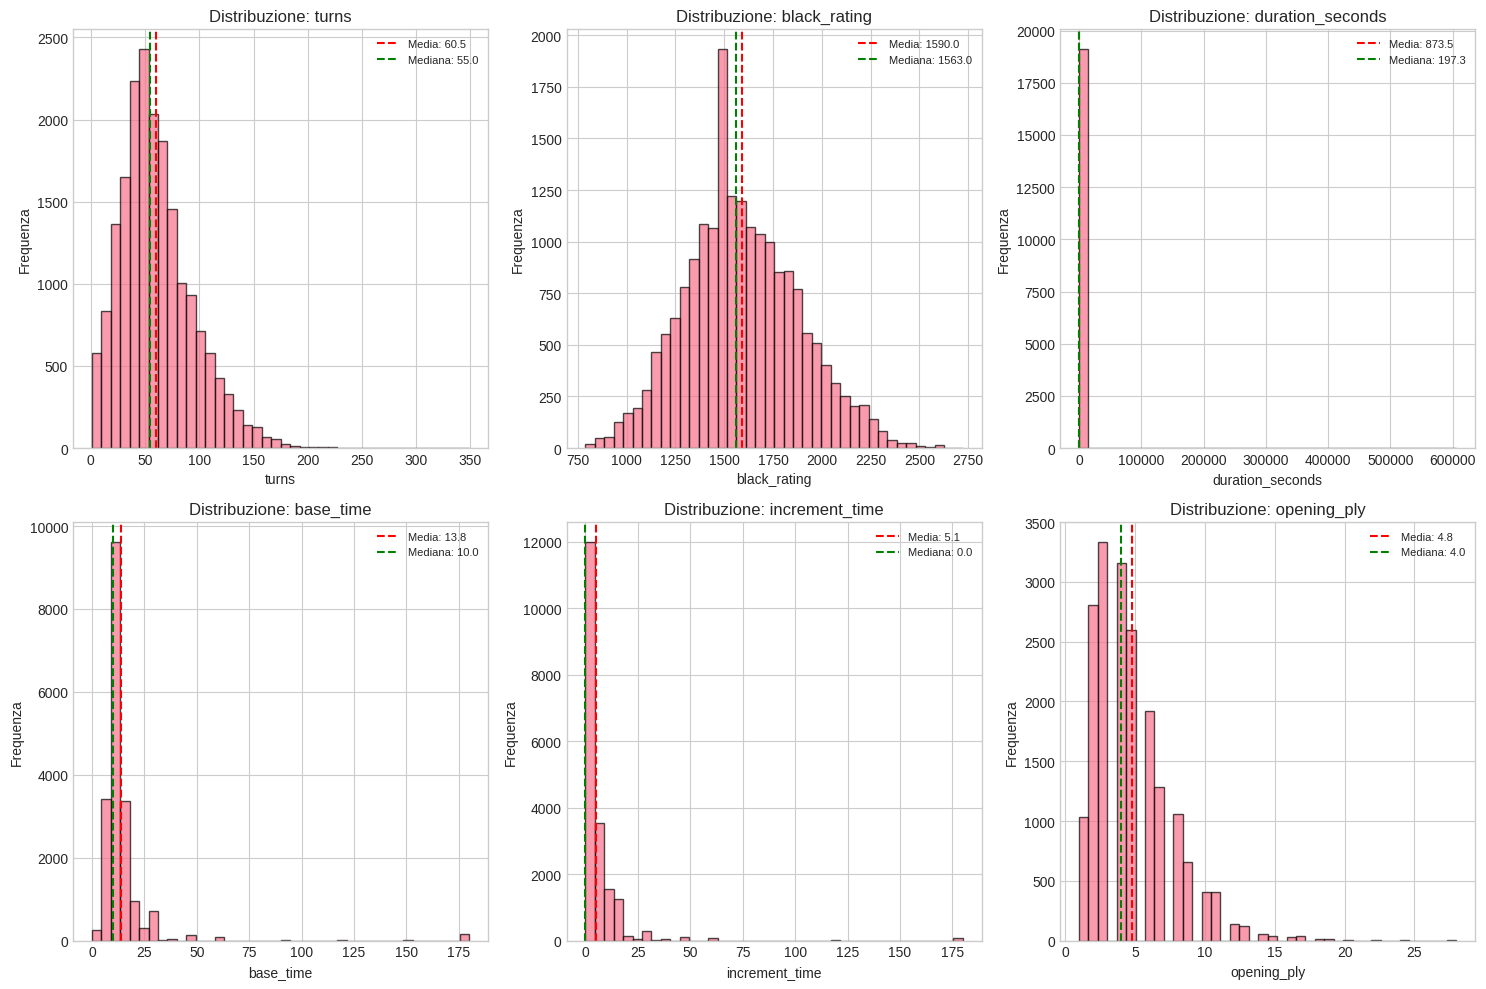

STATISTICHE FEATURES NUMERICHE
          turns  black_rating  duration_seconds  base_time  increment_time  \
count  19113.00      19113.00          19113.00   19113.00        19113.00   
mean      60.51       1590.05            873.45      13.79            5.15   
std       33.49        290.44           4927.36      17.07           13.81   
min        1.00        789.00              0.00       0.00            0.00   
25%       37.00       1394.00              0.00      10.00            0.00   
50%       55.00       1563.00            197.29      10.00            0.00   
75%       79.00       1785.00            781.05      15.00            7.00   
max      349.00       2723.00         605844.70     180.00          180.00   

       opening_ply  
count     19113.00  
mean          4.82  
std           2.80  
min           1.00  
25%           3.00  
50%           4.00  
75%           6.00  
max          28.00  


In [ ]:
features_to_analyze = ['turns', 'black_rating', 'duration_seconds',
                       'base_time', 'increment_time', 'opening_ply']
features_to_analyze = [f for f in features_to_analyze if f in df.columns]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, feature in enumerate(features_to_analyze):
    ax = axes[idx]
    ax.hist(df[feature], bins=40, alpha=0.7, edgecolor='black')
    ax.axvline(df[feature].mean(), color='red', linestyle='--', label=f'Media: {df[feature].mean():.1f}')
    ax.axvline(df[feature].median(), color='green', linestyle='--', label=f'Mediana: {df[feature].median():.1f}')
    ax.set_title(f'Distribuzione: {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequenza')
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

# Statistiche descrittive per tutte le features numeriche
print("STATISTICHE FEATURES NUMERICHE")
print(df[features_to_analyze].describe().round(2))

**Osservazioni sulle distribuzioni:**

- **turns**: Distribuzione asimmetrica positiva (media 60, mediana 55). La maggior parte delle partite dura 40-80 mosse, con una coda di partite molto lunghe (max 349).

- **black_rating**: Distribuzione simile a `white_rating` (media ~1590, std ~290), confermando l'effetto matchmaking.

- **duration_seconds**: Distribuzione problematica. La mediana (197s) è molto inferiore alla media (873s), indicando forte asimmetria. Il 25° percentile è 0, confermando il problema dei dati corrotti.

- **base_time**: Distribuzione discreta concentrata su pochi valori. Il formato 10 minuti (Blitz) domina con ~47% delle partite.

- **opening_ply**: Distribuzione compatta (media 4.8, range 1-28). La maggior parte delle aperture dura 3-6 ply.


### 4.7. Analisi Fetaure categoriche vs Target

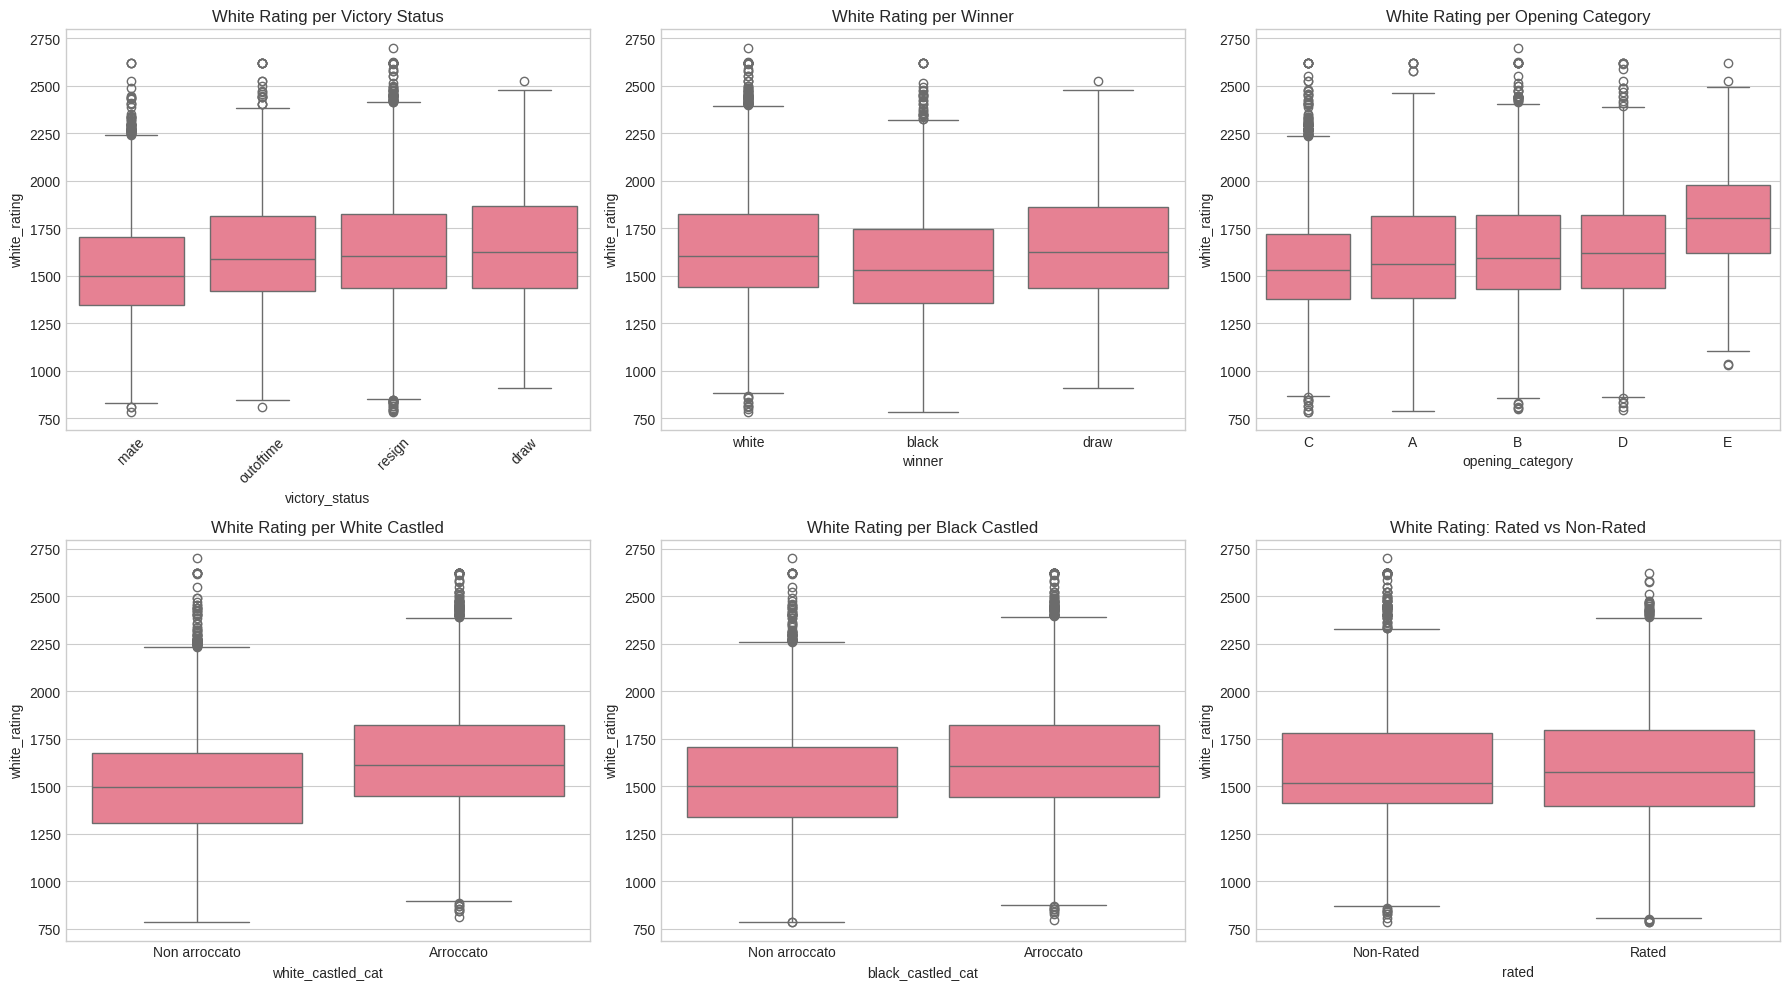

STATISTICHE WHITE_RATING PER CATEGORIA

VICTORY_STATUS:
                  mean  median    std  count
victory_status                              
draw            1652.2  1625.0  309.9    846
resign          1628.7  1605.0  291.9  10695
outoftime       1612.4  1585.0  297.9   1598
mate            1529.2  1500.0  269.0   5974

WINNER:
          mean  median    std  count
winner                              
draw    1649.3  1623.5  308.9    888
white   1634.7  1603.0  288.8   9545
black   1550.8  1527.0  282.5   8680

OPENING_CATEGORY:
                    mean  median    std  count
opening_category                              
E                 1794.7  1803.0  277.3    489
D                 1627.4  1619.0  288.6   2562
B                 1622.8  1594.0  293.4   5010
A                 1593.1  1562.0  306.7   3773
C                 1558.1  1530.0  271.1   7279

WHITE_CASTLED_CAT:
                     mean  median    std  count
white_castled_cat                              
Arroccato       

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
# --- VICTORY STATUS ---
victory_cols = [col for col in df.columns if col.startswith('victory_status_')]
df_temp['victory_status'] = None
for col in victory_cols:
    status = col.replace('victory_status_', '')
    df_temp.loc[df[col] == 1, 'victory_status'] = status

order_vs = df_temp.groupby('victory_status')['white_rating'].median().sort_values().index
sns.boxplot(data=df_temp, x='victory_status', y='white_rating', order=order_vs, ax=axes[0,0])
axes[0,0].set_title('White Rating per Victory Status')
axes[0,0].tick_params(axis='x', rotation=45)

# --- WINNER ---
winner_cols = [col for col in df.columns if col.startswith('winner_')]
df_temp['winner'] = None
for col in winner_cols:
    outcome = col.replace('winner_', '')
    df_temp.loc[df[col] == 1, 'winner'] = outcome

sns.boxplot(data=df_temp, x='winner', y='white_rating', ax=axes[0,1])
axes[0,1].set_title('White Rating per Winner')

# --- OPENING CATEGORY ---
opening_cols = [col for col in df.columns if col.startswith('opening_category_')]
df_temp['opening_category'] = None
for col in opening_cols:
    cat = col.replace('opening_category_', '')
    df_temp.loc[df[col] == 1, 'opening_category'] = cat

order_oc = df_temp.groupby('opening_category')['white_rating'].median().sort_values().index
sns.boxplot(data=df_temp, x='opening_category', y='white_rating', order=order_oc, ax=axes[0,2])
axes[0,2].set_title('White Rating per Opening Category')

# --- WHITE CASTLED ---
df_temp['white_castled_cat'] = df['white_castled'].map({1: 'Arroccato', 0: 'Non arroccato'})
sns.boxplot(data=df_temp, x='white_castled_cat', y='white_rating', ax=axes[1,0])
axes[1,0].set_title('White Rating per White Castled')

# --- BLACK CASTLED ---
df_temp['black_castled_cat'] = df['black_castled'].map({1: 'Arroccato', 0: 'Non arroccato'})
sns.boxplot(data=df_temp, x='black_castled_cat', y='white_rating', ax=axes[1,1])
axes[1,1].set_title('White Rating per Black Castled')

# --- RATED ---
df_temp['rated'] = df['rated_True'].map({1: 'Rated', 0: 'Non-Rated'})
sns.boxplot(data=df_temp, x='rated', y='white_rating', ax=axes[1,2])
axes[1,2].set_title('White Rating: Rated vs Non-Rated')

plt.tight_layout()
plt.show()

# Tabelle riassuntive
print("="*60)
print("STATISTICHE WHITE_RATING PER CATEGORIA")
print("="*60)

categorie = ['victory_status', 'winner', 'opening_category',
             'white_castled_cat', 'black_castled_cat', 'rated']

for cat in categorie:
    if cat in df_temp.columns:
        print(f"\n{cat.upper()}:")
        stats = df_temp.groupby(cat)['white_rating'].agg(['mean', 'median', 'std', 'count'])
        stats = stats.sort_values('median', ascending=False).round(1)
        print(stats)

**Interpretazione delle feature categoriche:**

**Victory Status** - Feature informativa:
| Status | Mediana ELO | Interpretazione |
|--------|-------------|-----------------|
| mate | 1500 | Giocatori più deboli (non riconoscono posizioni perse) |
| outoftime | 1585 | Livello intermedio |
| resign | 1605 | Giocatori più forti (abbandonano quando è perso) |
| draw | 1625 | Giocatori più forti (sanno difendere posizioni difficili) |

**Opening Category** - Feature molto informativa:
- **E** (Difese Indiane): Mediana 1803 - aperture complesse, giocate da esperti
- **D** (Partite di Donna): Mediana 1619
- **B** (Sistemi semiaperti): Mediana 1594
- **A** (Aperture atipiche): Mediana 1562
- **C** (Partite aperte): Mediana 1530 - più accessibili ai principianti

La differenza tra categoria E e C è di **273 punti ELO** - molto significativa.

**Arrocco** - Feature informativa:
- Chi arrocca ha mediana ~110 punti ELO superiore (sia per bianco che per nero)
- Indica conoscenza dei principi fondamentali del gioco

**Rated** - Feature NON informativa:
- Mediane quasi identiche (1577 vs 1515)
- L'ipotesi iniziale (sezione 1.2.C) è **falsificata**
- Decisione: escludere `rated_True` dal modello


### 4.8. Consistenza dei Dati

In [ ]:
# -----------------------------------------------------------------------------
# 7. OUTLIER DETECTION
# -----------------------------------------------------------------------------
print("ANALISI OUTLIER")

for feature in ['white_rating', 'black_rating', 'turns', 'duration_seconds']:
    if feature not in df.columns:
        continue
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    print(f"\n{feature}:")
    print(f"  Range IQR: [{lower_bound:.1f}, {upper_bound:.1f}]")
    print(f"  Outlier: {len(outliers)} ({100*len(outliers)/len(df):.2f}%)")

# -----------------------------------------------------------------------------
# 8. ANALISI CONSISTENZA DATI
# -----------------------------------------------------------------------------

print("CHECK DI CONSISTENZA")

# Partite con durata 0
if 'duration_seconds' in df.columns:
    zero_duration = (df['duration_seconds'] == 0).sum()
    print(f"\nPartite con durata = 0s: {zero_duration} ({100*zero_duration/len(df):.1f}%)")

# Opening ply > turns * 2
if 'opening_ply' in df.columns and 'turns' in df.columns:
    invalid_ply = (df['opening_ply'] > df['turns'] * 2).sum()
    print(f"Partite con opening_ply > turns*2: {invalid_ply}")

# Partite molto corte (< 5 mosse)
if 'turns' in df.columns:
    very_short = (df['turns'] < 5).sum()
    print(f"Partite con meno di 5 turni: {very_short} ({100*very_short/len(df):.1f}%)")

# Distribuzione controllo tempo
if 'base_time' in df.columns:
    print("\nDistribuzione controllo tempo (base_time in minuti):")
    print(df['base_time'].value_counts().head(10))

ANALISI OUTLIER

white_rating:
  Range IQR: [814.5, 2378.5]
  Outlier: 130 (0.68%)

black_rating:
  Range IQR: [807.5, 2371.5]
  Outlier: 92 (0.48%)

turns:
  Range IQR: [-26.0, 142.0]
  Outlier: 412 (2.16%)

duration_seconds:
  Range IQR: [-1171.6, 1952.6]
  Outlier: 1386 (7.25%)
CHECK DI CONSISTENZA

Partite con durata = 0s: 8533 (44.6%)
Partite con opening_ply > turns*2: 0
Partite con meno di 5 turni: 318 (1.7%)

Distribuzione controllo tempo (base_time in minuti):
base_time
10    8987
15    3219
5     1748
20     902
8      888
30     712
7      600
25     309
9      249
12     218
Name: count, dtype: int64


**Riepilogo qualità dei dati:**

**Outlier:**
- `white_rating` e `black_rating`: < 1% di outlier - trascurabili, nessuna azione
- `turns`: 2.16% outlier (partite molto lunghe) - manteniamo, sono partite reali
- `duration_seconds`: 7.25% outlier oltre al 44.6% corrotti - feature da escludere

**Problemi critici identificati:**

| Problema | Entità | Azione |
|----------|--------|--------|
| `duration_seconds` = 0 | 44.6% | ❌ Escludere feature (bug dataset Kaggle) |
| Partite < 5 turni | 1.7% (318) | ❌ Rimuovere righe (abbandoni immediati) |
| `opening_ply` > `turns*2` | 0 | ✅ Dati coerenti |
| Outlier rating | < 1% | ✅ Mantenere |

**Distribuzione controllo tempo:**
Il dataset è dominato da partite Blitz (10 min: 47%) e Rapid (15 min: 17%). Poche partite Bullet (5 min: 9%) e Classical (20+ min: ~10%).


### 4.9. Interpretazione Complessiva dell'Analisi Esplorativa

#### A. Correlazione white_rating / black_rating (Sezione 4.1)

La correlazione di **r = 0.6366** conferma l'ipotesi iniziale sul matchmaking, ma non è così alta da rendere il problema banale. Con R² ≈ 0.41, il rating dell'avversario spiega solo il 41% della varianza del target, lasciando spazio significativo alle altre feature.

#### B. Rated vs Non-Rated (Sezione 4.2)

**Ipotesi falsificata**: Contrariamente a quanto ipotizzato nell'introduzione, non emerge alcuna differenza significativa tra partite classificate e non classificate (media 1597.6 vs 1595.9). L'unica differenza è una maggiore varianza nelle non-rated (std 315.9 vs 283.6).

**Decisione**: La feature `rated_True` verrà esclusa dal modello.

#### C. Distribuzione del Target (Sezione 4.3)

La distribuzione di `white_rating` è **quasi normale** (skewness ≈ 0.29, kurtosis ≈ 0.02). Non sono necessarie trasformazioni.

#### D. Correlazioni con il Target (Sezioni 4.4-4.5)

| Feature | r | Decisione |
|---------|---|-----------|
| `black_rating` | **+0.64** | ✅ Mantenere |
| `opening_ply` | **+0.28** | ✅ Mantenere |
| `turns` | +0.13 | ✅ Mantenere |
| `black_checks_rate` | **-0.14** | ✅ Mantenere |
| `black_captures_rate` | -0.10 | ✅ Mantenere |
| `base_time` | -0.07 | ❌ Escludere |
| `black_promotions_rate` | -0.05 | ❌ Escludere |
| `white_checks_rate` | -0.04 | ❌ Escludere |
| `white_captures_rate` | +0.03 | ❌ Escludere |
| `increment_time` | -0.02 | ❌ Escludere |
| `duration_seconds` | +0.01 | ❌ Escludere (+ 44.6% corrotti) |
| `white_promotions_rate` | +0.01 | ❌ Escludere |

#### E. Feature Categoriche (Sezione 4.7)

**Victory Status** - Informativa:
- `mate` (media 1529) < `outoftime` (1612) < `resign` (1629) < `draw` (1652)
- Interpretazione: giocatori esperti riconoscono posizioni perse e abbandonano; le patte richiedono abilità difensiva

**Winner** - Informativa:
- `black` (media 1551) < `white` (1635) < `draw` (1649)
- Interpretazione: quando il bianco vince, tende ad avere ELO più alto; le patte avvengono tra giocatori più forti

**Opening Category** - Molto informativa:
- C (1558) < A (1593) < B (1623) < D (1627) < E (1795)
- Differenza E vs C = **237 punti ELO**
- Le Difese Indiane (E) sono giocate da esperti

**Arrocco** - Informativa:
- `white_castled`: Arroccato (1637) vs Non arroccato (1501) = **+136 punti**
- `black_castled`: Arroccato (1632) vs Non arroccato (1534) = **+98 punti**
- Interpretazione: l'arrocco indica conoscenza dei principi fondamentali

**Rated** - Non informativa:
- Rated (1598) ≈ Non-Rated (1596)
- Nessuna differenza significativa → **Escludere**

Pertanto:
|Feature	|Δ Mediana (max-min)	|Decisione|
|---------|---------------------|---------|
|opening_category_*	|237 punti (E vs C)	|✅ Mantenere|
|white_castled	|136 punti	|✅ Mantenere|
|black_castled	|98 punti	|✅ Mantenere|
|winner_*	98 punti |(draw vs black)|	✅ Mantenere|
|victory_status_*	|123 punti (draw vs mate)|	✅ Mantenere|
|rated_True	|2 punti	|❌ Escludere|

#### F. Qualità dei Dati e Outliers (Sezione 4.8)

| Problema | Entità | Azione |
|----------|--------|--------|
| `duration_seconds` = 0 | 44.6% | Escludere feature |
| Partite < 5 turni | 1.7% | Rimuovere righe |
| Outlier rating | < 1% | Mantenere |


## 5. Preparazione Dati per implementazione del modello

### 5.1. Rimozioni Feature post-EDA

In [ ]:
print(f"\nDimensione iniziale: {df.shape[0]} righe, {df.shape[1]} colonne")

features_da_rimuovere = [
    # --- Features numeriche (|r| < 0.10 con target) ---
    'duration_seconds',       # r = +0.01, + 44.6% valori corrotti
    'base_time',              # r = -0.07
    'increment_time',         # r = -0.02
    'white_captures_rate',    # r = +0.03
    'white_checks_rate',      # r = -0.04
    'white_promotions_rate',  # r ≈ 0
    'black_promotions_rate',  # r ≈ 0

    # --- Features categoriche (Δ mediana < 10 punti) ---
    'rated_True',             # Δ = 2 punti (non informativa)
    'rated_False',            # Analaìoga a quella sopra
]

# Rimuovi solo le colonne che esistono nel dataframe
features_esistenti = [f for f in features_da_rimuovere if f in df.columns]
df = df.drop(columns=features_esistenti)

print(f"\nRimosse {len(features_esistenti)} features:")
for f in features_esistenti:
    print(f"  ✗ {f}")




df.head(5)


Dimensione iniziale: 19113 righe, 29 colonne

Rimosse 9 features:
  ✗ duration_seconds
  ✗ base_time
  ✗ increment_time
  ✗ white_captures_rate
  ✗ white_checks_rate
  ✗ white_promotions_rate
  ✗ black_promotions_rate
  ✗ rated_True
  ✗ rated_False


,turns,white_rating,black_rating,opening_ply,black_captures_rate,black_checks_rate,white_castled,black_castled,victory_status_draw,victory_status_mate,victory_status_outoftime,victory_status_resign,winner_black,winner_draw,winner_white,opening_category_A,opening_category_B,opening_category_C,opening_category_D,opening_category_E
0,13,1500,1191,5,0.166667,0.166667,0,0,0,0,1,0,0,0,1,0,0,0,1,0
1,16,1322,1261,4,0.375000,0.125000,0,0,0,0,0,1,1,0,0,0,1,0,0,0
2,61,1496,1500,3,0.100000,0.000000,0,0,0,1,0,0,0,0,1,0,0,1,0,0
3,61,1439,1454,3,0.133333,0.000000,1,1,0,1,0,0,0,0,1,0,0,0,1,0
4,95,1523,1469,5,0.212766,0.085106,1,1,0,1,0,0,0,0,1,0,0,1,0,0
